In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
    df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
    cols = list(df.columns)
    cols = cols[1:] + [cols[0]] 
    df = df[cols]
    
    return df

In [4]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [5]:
def testCO2Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['co2'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel CO2 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de CO2')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [6]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [7]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [8]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72


In [9]:
df_lags_5 = lags(df_final, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,28.09,28.03,27.94,27.66,27.34,48.43,48.59,49.70,49.45,49.74,...,5.71,6.38,7.75,13.00,586.75,581.25,578.66,590.77,594.85,579.95
1,28.06,28.09,28.03,27.94,27.66,48.02,48.43,48.59,49.70,49.45,...,4.62,5.71,6.38,7.75,579.95,586.75,581.25,578.66,590.77,609.86
2,25.93,28.06,28.09,28.03,27.94,51.06,48.02,48.43,48.59,49.70,...,4.62,4.62,5.71,6.38,609.86,579.95,586.75,581.25,578.66,616.17
3,25.96,25.93,28.06,28.09,28.03,50.89,51.06,48.02,48.43,48.59,...,31.75,4.62,4.62,5.71,616.17,609.86,579.95,586.75,581.25,617.56
4,25.99,25.96,25.93,28.06,28.09,50.76,50.89,51.06,48.02,48.43,...,36.88,31.75,4.62,4.62,617.56,616.17,609.86,579.95,586.75,620.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,19.70,19.10,18.50,18.50,409.86,409.15,408.77,408.92,409.00,409.35
16846,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,20.10,19.70,19.10,18.50,409.35,409.86,409.15,408.77,408.92,408.84
16847,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,20.40,20.10,19.70,19.10,408.84,409.35,409.86,409.15,408.77,408.72
16848,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,20.80,20.40,20.10,19.70,408.72,408.84,409.35,409.86,409.15,408.75


In [10]:
df_lags_10 = lags(df_final, 10) #predecir a 10 minutos
df_lags_10 = df_lags_10.iloc[10:,:].reset_index(drop=True)
df_lags_10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_co2_6,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,co2
0,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,27.34,...,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,594.85,623.75
1,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,...,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,617.60
2,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,...,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,610.68
3,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,...,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,614.24
4,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,...,610.68,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,614.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.69,409.35
16841,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.84
16842,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,408.72
16843,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.84,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,408.75


In [11]:
df_lags_15 = lags(df_final, 15) #predecir a 15 minutos
df_lags_15 = df_lags_15.iloc[15:,:].reset_index(drop=True)
df_lags_15

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,Lag_co2_11,Lag_co2_12,Lag_co2_13,Lag_co2_14,Lag_co2_15,co2
0,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,...,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,594.85,606.56
1,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,...,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,590.77,602.53
2,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,...,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,578.66,601.45
3,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,...,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,581.25,596.29
4,26.18,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,...,610.68,617.60,623.75,620.53,617.56,616.17,609.86,579.95,586.75,592.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16835,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,408.49,409.79,409.20,408.69,408.38,408.45,408.87,409.12,409.72,409.35
16836,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.87,409.12,408.84
16837,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.00,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.87,408.72
16838,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.92,409.00,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.75


# Linear Regression

## 5 minutos

In [12]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_5 = pd.DataFrame(scaler.fit_transform(df_lags_5), columns=df_lags_5.columns)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_5.iloc[:,:-1], df_lags_norm_5.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [14]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [15]:
modelLR.coef_

array([[ 1.31547510e-01, -6.27869645e-03, -8.17456616e-02,
        -9.42365799e-03, -3.52914845e-02,  8.30461534e-02,
        -9.97289043e-02, -1.69941667e-02,  3.31617808e-02,
        -1.33500228e-04,  3.10439039e-01, -5.99620658e-01,
        -7.95174378e-01,  9.26461644e-01, -1.20750334e-01,
        -2.80531187e-01,  5.89061769e-01,  7.52343081e-01,
        -9.00753944e-01,  1.16354595e-01,  1.13280894e+00,
        -2.93495645e-02, -8.81931448e-03,  4.17943974e-03,
        -1.03604964e-01]])

In [16]:
modelLR.intercept_

array([0.0016442])

In [17]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

array([[0.11537059],
       [0.13520809],
       [0.13939314],
       ...,
       [0.00180401],
       [0.00182391],
       [0.00236777]])

In [18]:
# make predictions
trainPredict = modelLR.predict(X_train)
testPredict = modelLR.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
y_train_transformed = scaler.inverse_transform(y_train.to_numpy())
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_transformed, trainPredict.ravel()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_transformed, testPredict.ravel()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.62 RMSE
Test Score: 10.03 RMSE


In [20]:
# Recursive predictions
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

rmse_5, mae_5, preds_5 = recursiveStepsAhead(X_test, y_test, 5, scaler, modelLR)

Test Score Step 1
RMSE 10.85
MAE 4.63
Test Score Step 2
RMSE 13.66
MAE 7.12
Test Score Step 3
RMSE 17.35
MAE 9.86
Test Score Step 4
RMSE 21.22
MAE 12.66
Test Score Step 5
RMSE 25.23
MAE 15.47


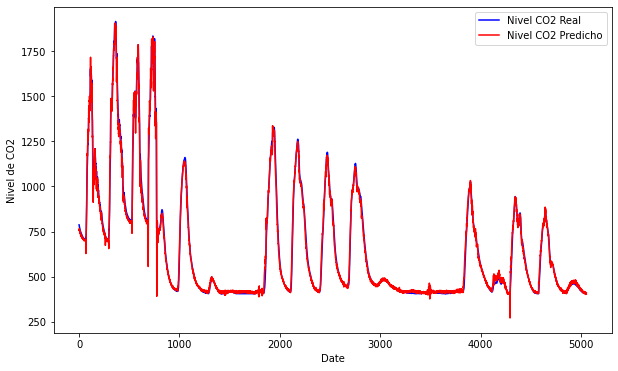

In [21]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_5[4] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

## 10 minutos

In [22]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_10 = pd.DataFrame(scaler.fit_transform(df_lags_10), columns=df_lags_10.columns)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_10.iloc[:,:-1], df_lags_norm_10.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [24]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [25]:
modelLR.coef_

array([[ 0.12582064, -0.00158447, -0.09490568, -0.0147944 ,  0.02346009,
        -0.00570566, -0.05653884,  0.02484114,  0.01046011, -0.0127993 ,
         0.09043518, -0.09854649, -0.01832968,  0.03549905,  0.00210183,
        -0.05968819,  0.03385105,  0.0203004 , -0.04604631,  0.03969555,
         0.40539311, -0.91024234, -0.85830576,  1.03122449, -0.25942131,
        -0.11511318,  0.61815303,  0.17080475, -0.09627733, -0.38810285,
        -0.38255486,  0.89986824,  0.82293127, -1.00396336,  0.24701705,
         0.13433581, -0.66814808, -0.14535522,  0.12719773,  0.37186513,
         1.12751929, -0.03145474, -0.01026204,  0.00530765, -0.08612519,
         0.02310915, -0.01940202, -0.02781952,  0.01813754, -0.00448614]])

In [26]:
modelLR.intercept_

array([0.00170168])

In [27]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_10['co2'].to_numpy().reshape(-1, 1))

rmse_10, mae_10, preds_10 = recursiveStepsAhead(X_test, y_test, 10, scaler, modelLR)

Test Score Step 1
RMSE 11.15
MAE 5.09
Test Score Step 2
RMSE 14.45
MAE 7.95
Test Score Step 3
RMSE 18.72
MAE 11.08
Test Score Step 4
RMSE 23.22
MAE 14.31
Test Score Step 5
RMSE 27.88
MAE 17.56
Test Score Step 6
RMSE 32.58
MAE 20.82
Test Score Step 7
RMSE 37.28
MAE 24.09
Test Score Step 8
RMSE 42.01
MAE 27.36
Test Score Step 9
RMSE 46.73
MAE 30.62
Test Score Step 10
RMSE 51.44
MAE 33.88


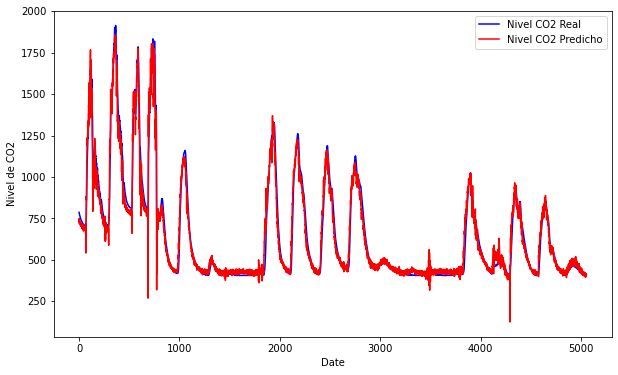

In [28]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_10[9] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

## 15 minutos

In [29]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_15 = pd.DataFrame(scaler.fit_transform(df_lags_15), columns=df_lags_15.columns)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_15.iloc[:,:-1], df_lags_norm_15.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [31]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [32]:
modelLR.coef_

array([[ 1.22868053e-01, -2.00016025e-03, -9.08278057e-02,
        -1.81193715e-02,  1.65194050e-02, -9.71209662e-03,
        -2.73165884e-02,  1.78867303e-02, -4.24662034e-03,
         2.57869761e-03, -2.09053572e-02,  4.95900530e-02,
        -5.15729204e-02, -2.40061696e-02,  3.80024704e-02,
         8.85989003e-02, -9.87514371e-02, -1.50854263e-02,
         3.66001419e-02,  1.10443394e-03, -5.73322496e-02,
         3.65847412e-02,  1.72945548e-02, -4.30600726e-02,
         4.75316874e-02, -4.21537264e-02,  5.63935397e-03,
         1.40153228e-02,  2.10306951e-02, -1.29245416e-02,
         4.48571962e-01, -7.13365311e-01, -8.52297621e-01,
         8.59857712e-01, -1.43297441e-02, -2.88266854e-02,
         1.03435510e+00, -4.07904863e-02, -4.30199991e-01,
         2.68337788e-01, -9.26586512e-01, -9.20279241e-01,
         6.28592390e-01,  8.12124276e-01, -1.03343387e-01,
        -4.26610171e-01,  7.01975305e-01,  8.18740299e-01,
        -8.30857866e-01,  5.61159137e-04,  5.49504873e-0

In [33]:
modelLR.intercept_

array([0.00168078])

In [34]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_15['co2'].to_numpy().reshape(-1, 1))

rmse_15, mae_15, preds_15 = recursiveStepsAhead(X_test, y_test, 15, scaler, modelLR)

Test Score Step 1
RMSE 11.31
MAE 5.40
Test Score Step 2
RMSE 14.84
MAE 8.48
Test Score Step 3
RMSE 19.36
MAE 11.85
Test Score Step 4
RMSE 24.12
MAE 15.34
Test Score Step 5
RMSE 29.04
MAE 18.86
Test Score Step 6
RMSE 34.03
MAE 22.40
Test Score Step 7
RMSE 39.04
MAE 25.95
Test Score Step 8
RMSE 44.13
MAE 29.53
Test Score Step 9
RMSE 49.25
MAE 33.12
Test Score Step 10
RMSE 54.39
MAE 36.71
Test Score Step 11
RMSE 59.53
MAE 40.29
Test Score Step 12
RMSE 64.64
MAE 43.86
Test Score Step 13
RMSE 69.74
MAE 47.43
Test Score Step 14
RMSE 74.80
MAE 50.98
Test Score Step 15
RMSE 79.84
MAE 54.52


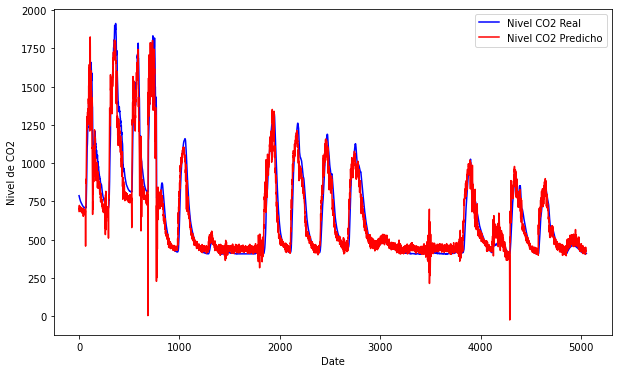

In [35]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_15[14] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

# Random Forest

Test Score Step 1
RMSE 30.81
MAE 14.81
Test Score Step 2
RMSE 35.60
MAE 20.52
Test Score Step 3
RMSE 42.72
MAE 27.28
Test Score Step 4
RMSE 52.18
MAE 35.23
Test Score Step 5
RMSE 64.61
MAE 44.64


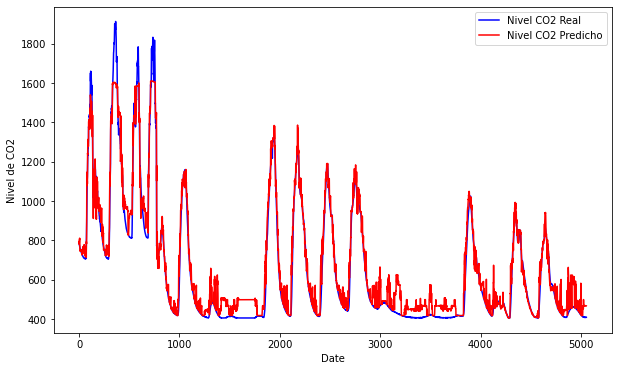

In [36]:
rmse_rf_5, mae_rf_5, preds_rf_5 = testCO2Quality(df_lags_5, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 33.19
MAE 15.59
Test Score Step 2
RMSE 38.22
MAE 21.55
Test Score Step 3
RMSE 45.32
MAE 28.40
Test Score Step 4
RMSE 54.61
MAE 36.42
Test Score Step 5
RMSE 67.79
MAE 46.61
Test Score Step 6
RMSE 83.22
MAE 57.73
Test Score Step 7
RMSE 102.51
MAE 70.75
Test Score Step 8
RMSE 122.58
MAE 84.06
Test Score Step 9
RMSE 140.13
MAE 95.81
Test Score Step 10
RMSE 154.69
MAE 105.75


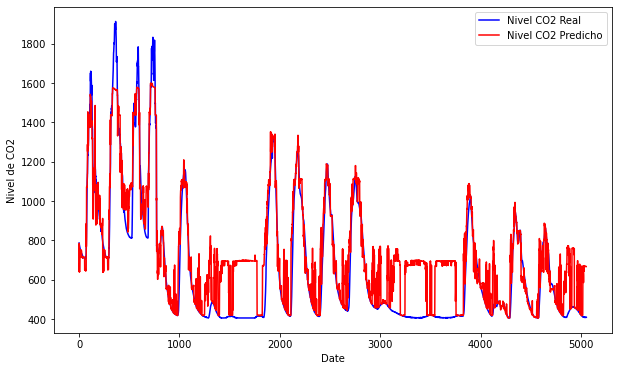

In [37]:
rmse_rf_10, mae_rf_10, preds_rf_10 = testCO2Quality(df_lags_10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 34.69
MAE 16.13
Test Score Step 2
RMSE 39.24
MAE 21.93
Test Score Step 3
RMSE 45.92
MAE 28.83
Test Score Step 4
RMSE 54.31
MAE 36.38
Test Score Step 5
RMSE 66.47
MAE 46.23
Test Score Step 6
RMSE 81.00
MAE 57.23
Test Score Step 7
RMSE 101.26
MAE 71.33
Test Score Step 8
RMSE 120.78
MAE 84.66
Test Score Step 9
RMSE 138.62
MAE 96.99
Test Score Step 10
RMSE 153.12
MAE 107.32
Test Score Step 11
RMSE 170.66
MAE 118.95
Test Score Step 12
RMSE 186.55
MAE 129.48
Test Score Step 13
RMSE 198.39
MAE 137.67
Test Score Step 14
RMSE 211.96
MAE 146.59
Test Score Step 15
RMSE 224.22
MAE 154.65


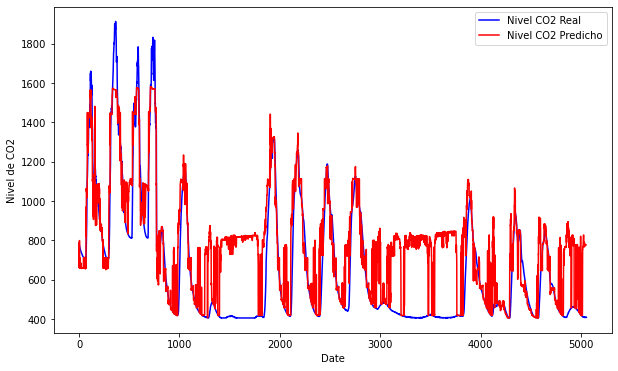

In [38]:
rmse_rf_15, mae_rf_15, preds_rf_15 = testCO2Quality(df_lags_15, 15, RandomForestRegressor(random_state=seed_value))

# PM2.5

In [12]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm25 = np.sum([len(re.findall("Lag_pm25*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm25], prueba_X_test.iloc[:,-lagspm25:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm25_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [13]:
def testPM25Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm25'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM2.5 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM2.5 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM2.5')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [14]:
df_final_pm25 = df_final[['temperature', 'relativehumidity', 'pm10', 'co2', 'pm25']]

In [15]:
df_lags_5_pm25 = lags(df_final_pm25, 5) #predecir a 5 minutos
df_lags_5_pm25 = df_lags_5_pm25.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm25_1,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,pm25
0,28.09,28.03,27.94,27.66,27.34,48.43,48.59,49.70,49.45,49.74,...,581.25,578.66,590.77,594.85,3.62,4.71,5.38,6.75,11.88,3.62
1,28.06,28.09,28.03,27.94,27.66,48.02,48.43,48.59,49.70,49.45,...,586.75,581.25,578.66,590.77,3.62,3.62,4.71,5.38,6.75,29.75
2,25.93,28.06,28.09,28.03,27.94,51.06,48.02,48.43,48.59,49.70,...,579.95,586.75,581.25,578.66,29.75,3.62,3.62,4.71,5.38,34.88
3,25.96,25.93,28.06,28.09,28.03,50.89,51.06,48.02,48.43,48.59,...,609.86,579.95,586.75,581.25,34.88,29.75,3.62,3.62,4.71,37.14
4,25.99,25.96,25.93,28.06,28.09,50.76,50.89,51.06,48.02,48.43,...,616.17,609.86,579.95,586.75,37.14,34.88,29.75,3.62,3.62,38.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,409.15,408.77,408.92,409.00,19.10,18.70,18.10,17.50,17.50,19.40
16846,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,409.86,409.15,408.77,408.92,19.40,19.10,18.70,18.10,17.50,19.80
16847,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,409.35,409.86,409.15,408.77,19.80,19.40,19.10,18.70,18.10,20.80
16848,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,408.84,409.35,409.86,409.15,20.80,19.80,19.40,19.10,18.70,20.40


In [16]:
df_lags_10_pm25 = lags(df_final_pm25, 10) #predecir a 10 minutos
df_lags_10_pm25 = df_lags_10_pm25.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,Lag_pm25_6,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,pm25
0,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,27.34,...,37.14,34.88,29.75,3.62,3.62,4.71,5.38,6.75,11.88,38.50
1,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,...,38.38,37.14,34.88,29.75,3.62,3.62,4.71,5.38,6.75,38.29
2,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,...,38.50,38.38,37.14,34.88,29.75,3.62,3.62,4.71,5.38,37.62
3,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,...,38.29,38.50,38.38,37.14,34.88,29.75,3.62,3.62,4.71,35.62
4,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,...,37.62,38.29,38.50,38.38,37.14,34.88,29.75,3.62,3.62,34.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,18.70,18.10,17.50,17.50,16.80,16.30,15.80,15.80,15.10,19.40
16841,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,19.10,18.70,18.10,17.50,17.50,16.80,16.30,15.80,15.80,19.80
16842,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,19.40,19.10,18.70,18.10,17.50,17.50,16.80,16.30,15.80,20.80
16843,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,19.80,19.40,19.10,18.70,18.10,17.50,17.50,16.80,16.30,20.40


In [17]:
df_lags_15_pm25 = lags(df_final_pm25, 15) #predecir a 15 minutos
df_lags_15_pm25 = df_lags_15_pm25.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,Lag_pm25_11,Lag_pm25_12,Lag_pm25_13,Lag_pm25_14,Lag_pm25_15,pm25
0,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,...,37.14,34.88,29.75,3.62,3.62,4.71,5.38,6.75,11.88,31.25
1,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,...,38.38,37.14,34.88,29.75,3.62,3.62,4.71,5.38,6.75,28.00
2,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,...,38.50,38.38,37.14,34.88,29.75,3.62,3.62,4.71,5.38,26.71
3,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,...,38.29,38.50,38.38,37.14,34.88,29.75,3.62,3.62,4.71,24.50
4,26.18,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,...,37.62,38.29,38.50,38.38,37.14,34.88,29.75,3.62,3.62,22.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16835,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,16.30,15.80,15.80,15.10,14.56,14.10,13.80,13.20,13.40,19.40
16836,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,16.80,16.30,15.80,15.80,15.10,14.56,14.10,13.80,13.20,19.80
16837,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,17.50,16.80,16.30,15.80,15.80,15.10,14.56,14.10,13.80,20.80
16838,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,17.50,17.50,16.80,16.30,15.80,15.80,15.10,14.56,14.10,20.40


## Linear Regression

Test Score Step 1
RMSE 2.49
MAE 1.70
Test Score Step 2
RMSE 7.47
MAE 5.10
Test Score Step 3
RMSE 43.20
MAE 29.49
Test Score Step 4
RMSE 205.44
MAE 140.41
Test Score Step 5
RMSE 1029.85
MAE 703.57


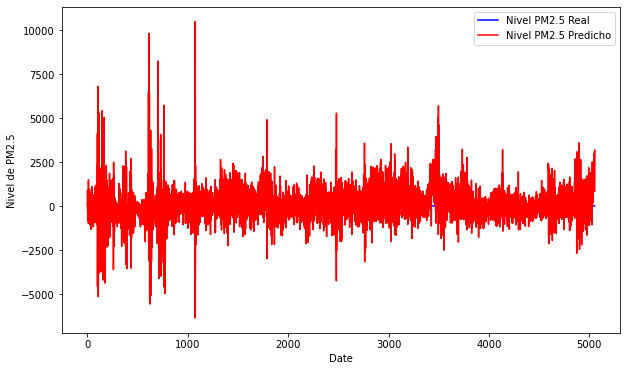

In [18]:
rmse_lr_5_pm25, mae_lr_5_pm25, preds_lr_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, LinearRegression())

Test Score Step 1
RMSE 2.86
MAE 1.92
Test Score Step 2
RMSE 13.57
MAE 8.91
Test Score Step 3
RMSE 96.70
MAE 63.87
Test Score Step 4
RMSE 631.75
MAE 416.91
Test Score Step 5
RMSE 4198.73
MAE 2771.19
Test Score Step 6
RMSE 27815.11
MAE 18357.76
Test Score Step 7
RMSE 184377.59
MAE 121688.19
Test Score Step 8
RMSE 1222044.33
MAE 806542.07
Test Score Step 9
RMSE 8099805.20
MAE 5345824.23
Test Score Step 10
RMSE 53685947.95
MAE 35432412.30


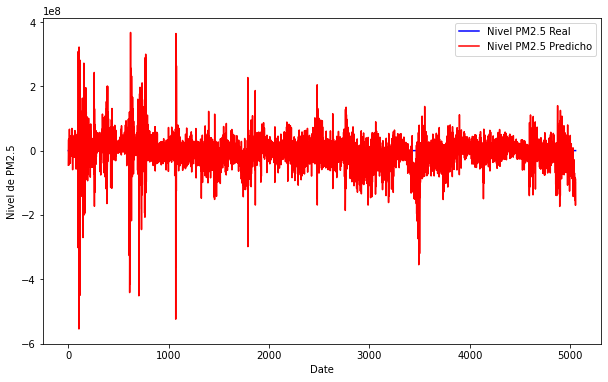

In [19]:
rmse_lr_10_pm25, mae_lr_10_pm25, preds_lr_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, LinearRegression())

Test Score Step 1
RMSE 3.13
MAE 2.05
Test Score Step 2
RMSE 15.08
MAE 9.63
Test Score Step 3
RMSE 111.09
MAE 71.45
Test Score Step 4
RMSE 742.54
MAE 477.10
Test Score Step 5
RMSE 5065.55
MAE 3255.27
Test Score Step 6
RMSE 34415.55
MAE 22115.73
Test Score Step 7
RMSE 234008.77
MAE 150376.99
Test Score Step 8
RMSE 1590899.01
MAE 1022330.63
Test Score Step 9
RMSE 10815976.32
MAE 6950476.47
Test Score Step 10
RMSE 73533713.57
MAE 47253647.01
Test Score Step 11
RMSE 499928278.41
MAE 321259914.86
Test Score Step 12
RMSE 3398825189.13
MAE 2184125877.07
Test Score Step 13
RMSE 23107340690.43
MAE 14849054586.40
Test Score Step 14
RMSE 157098162117.07
MAE 100953165310.60
Test Score Step 15
RMSE 1068051616065.33
MAE 686342792968.47


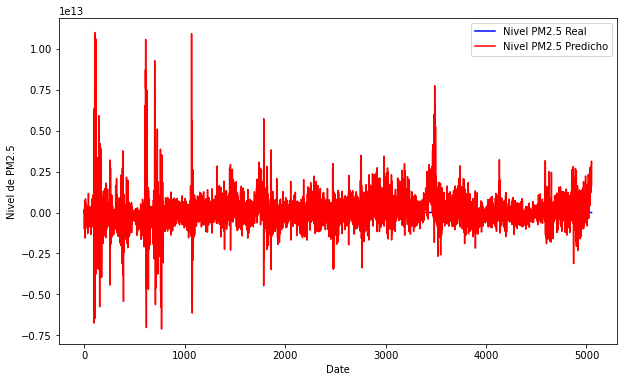

In [20]:
rmse_lr_15_pm25, mae_lr_15_pm25, preds_lr_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, LinearRegression())

## Random Forest

Test Score Step 1
RMSE 1.45
MAE 0.48
Test Score Step 2
RMSE 1.52
MAE 0.53
Test Score Step 3
RMSE 1.54
MAE 0.54
Test Score Step 4
RMSE 1.56
MAE 0.55
Test Score Step 5
RMSE 1.55
MAE 0.55


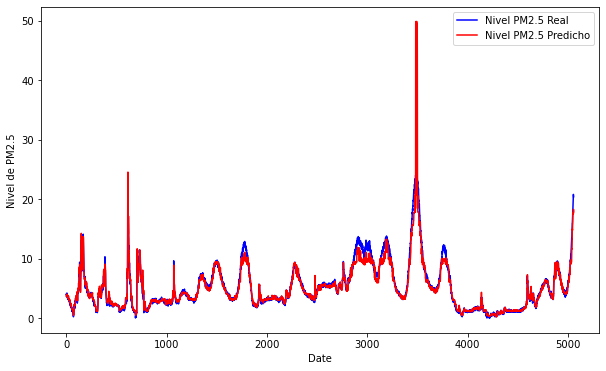

In [21]:
rmse_rf_5_pm25, mae_rf_5_pm25, preds_rf_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 0.78
MAE 0.46
Test Score Step 2
RMSE 0.85
MAE 0.48
Test Score Step 3
RMSE 0.97
MAE 0.50
Test Score Step 4
RMSE 1.13
MAE 0.51
Test Score Step 5
RMSE 1.15
MAE 0.52
Test Score Step 6
RMSE 1.15
MAE 0.52
Test Score Step 7
RMSE 1.14
MAE 0.52
Test Score Step 8
RMSE 1.14
MAE 0.52
Test Score Step 9
RMSE 1.14
MAE 0.52
Test Score Step 10
RMSE 1.14
MAE 0.52


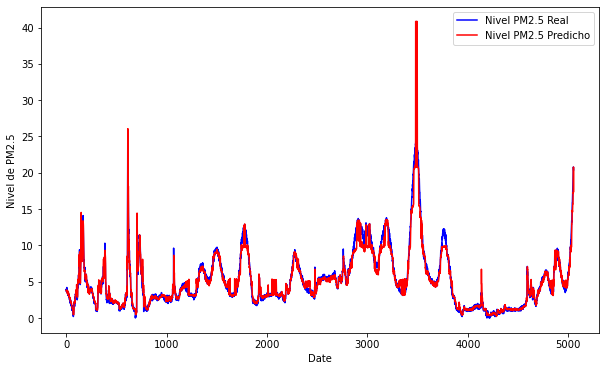

In [22]:
rmse_rf_10_pm25, mae_rf_10_pm25, preds_rf_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 0.85
MAE 0.50
Test Score Step 2
RMSE 0.89
MAE 0.53
Test Score Step 3
RMSE 0.90
MAE 0.54
Test Score Step 4
RMSE 0.91
MAE 0.54
Test Score Step 5
RMSE 0.91
MAE 0.54
Test Score Step 6
RMSE 0.92
MAE 0.55
Test Score Step 7
RMSE 0.91
MAE 0.55
Test Score Step 8
RMSE 0.92
MAE 0.55
Test Score Step 9
RMSE 0.91
MAE 0.55
Test Score Step 10
RMSE 0.92
MAE 0.55
Test Score Step 11
RMSE 0.91
MAE 0.55
Test Score Step 12
RMSE 0.92
MAE 0.55
Test Score Step 13
RMSE 0.91
MAE 0.55
Test Score Step 14
RMSE 0.91
MAE 0.55
Test Score Step 15
RMSE 0.91
MAE 0.55


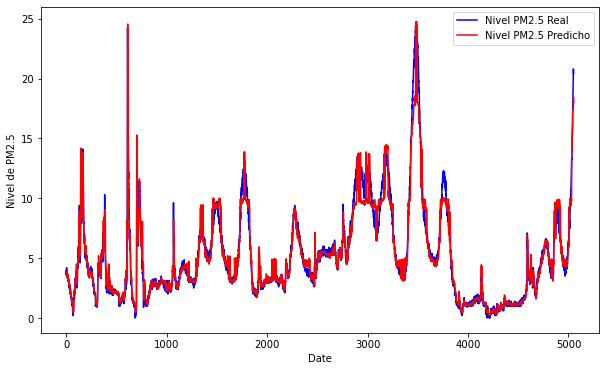

In [23]:
rmse_rf_15_pm25, mae_rf_15_pm25, preds_rf_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, RandomForestRegressor(random_state=seed_value))

# PM10

In [24]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE = [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm10 = np.sum([len(re.findall("Lag_pm10*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm10], prueba_X_test.iloc[:,-lagspm10:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm10_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        
    return testPredRMSE, testPredMAE, preds

In [25]:
def testPM10Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm10'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM10 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM10 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM10')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [26]:
df_final_pm10 = df_final[['temperature', 'relativehumidity', 'pm25', 'co2', 'pm10']]

In [27]:
df_lags_5_pm10 = lags(df_final_pm10, 5) #predecir a 5 minutos
df_lags_5_pm10 = df_lags_5_pm10.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,pm10
0,28.09,28.03,27.94,27.66,27.34,48.43,48.59,49.70,49.45,49.74,...,581.25,578.66,590.77,594.85,4.62,5.71,6.38,7.75,13.00,4.62
1,28.06,28.09,28.03,27.94,27.66,48.02,48.43,48.59,49.70,49.45,...,586.75,581.25,578.66,590.77,4.62,4.62,5.71,6.38,7.75,31.75
2,25.93,28.06,28.09,28.03,27.94,51.06,48.02,48.43,48.59,49.70,...,579.95,586.75,581.25,578.66,31.75,4.62,4.62,5.71,6.38,36.88
3,25.96,25.93,28.06,28.09,28.03,50.89,51.06,48.02,48.43,48.59,...,609.86,579.95,586.75,581.25,36.88,31.75,4.62,4.62,5.71,39.14
4,25.99,25.96,25.93,28.06,28.09,50.76,50.89,51.06,48.02,48.43,...,616.17,609.86,579.95,586.75,39.14,36.88,31.75,4.62,4.62,40.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,409.15,408.77,408.92,409.00,20.10,19.70,19.10,18.50,18.50,20.40
16846,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,409.86,409.15,408.77,408.92,20.40,20.10,19.70,19.10,18.50,20.80
16847,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,409.35,409.86,409.15,408.77,20.80,20.40,20.10,19.70,19.10,21.80
16848,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,408.84,409.35,409.86,409.15,21.80,20.80,20.40,20.10,19.70,21.40


In [28]:
df_lags_10_pm10 = lags(df_final_pm10, 10) #predecir a 10 minutos
df_lags_10_pm10 = df_lags_10_pm10.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_pm10_6,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,pm10
0,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,27.34,...,39.14,36.88,31.75,4.62,4.62,5.71,6.38,7.75,13.00,40.50
1,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,27.66,...,40.38,39.14,36.88,31.75,4.62,4.62,5.71,6.38,7.75,40.29
2,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,27.94,...,40.50,40.38,39.14,36.88,31.75,4.62,4.62,5.71,6.38,39.62
3,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,28.03,...,40.29,40.50,40.38,39.14,36.88,31.75,4.62,4.62,5.71,37.62
4,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,28.09,...,39.62,40.29,40.50,40.38,39.14,36.88,31.75,4.62,4.62,36.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16840,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,19.70,19.10,18.50,18.50,17.80,17.30,16.80,16.80,16.10,20.40
16841,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,20.10,19.70,19.10,18.50,18.50,17.80,17.30,16.80,16.80,20.80
16842,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,20.40,20.10,19.70,19.10,18.50,18.50,17.80,17.30,16.80,21.80
16843,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,20.80,20.40,20.10,19.70,19.10,18.50,18.50,17.80,17.30,21.40


In [29]:
df_lags_15_pm10 = lags(df_final_pm10, 15) #predecir a 15 minutos
df_lags_15_pm10 = df_lags_15_pm10.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,Lag_pm10_11,Lag_pm10_12,Lag_pm10_13,Lag_pm10_14,Lag_pm10_15,pm10
0,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,28.06,...,39.14,36.88,31.75,4.62,4.62,5.71,6.38,7.75,13.00,33.25
1,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,25.93,...,40.38,39.14,36.88,31.75,4.62,4.62,5.71,6.38,7.75,30.00
2,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,25.96,...,40.50,40.38,39.14,36.88,31.75,4.62,4.62,5.71,6.38,28.71
3,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,25.99,...,40.29,40.50,40.38,39.14,36.88,31.75,4.62,4.62,5.71,25.88
4,26.18,26.17,26.17,26.22,26.17,26.14,26.05,25.99,26.00,26.00,...,39.62,40.29,40.50,40.38,39.14,36.88,31.75,4.62,4.62,23.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16835,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,17.30,16.80,16.80,16.10,15.56,15.10,14.80,14.20,14.40,20.40
16836,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,17.80,17.30,16.80,16.80,16.10,15.56,15.10,14.80,14.20,20.80
16837,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,18.50,17.80,17.30,16.80,16.80,16.10,15.56,15.10,14.80,21.80
16838,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,18.50,18.50,17.80,17.30,16.80,16.80,16.10,15.56,15.10,21.40


## Linear Regression

Test Score Step 1
RMSE 2.51
MAE 1.69
Test Score Step 2
RMSE 17.19
MAE 11.64
Test Score Step 3
RMSE 92.60
MAE 62.58
Test Score Step 4
RMSE 467.39
MAE 315.63
Test Score Step 5
RMSE 2316.70
MAE 1564.05


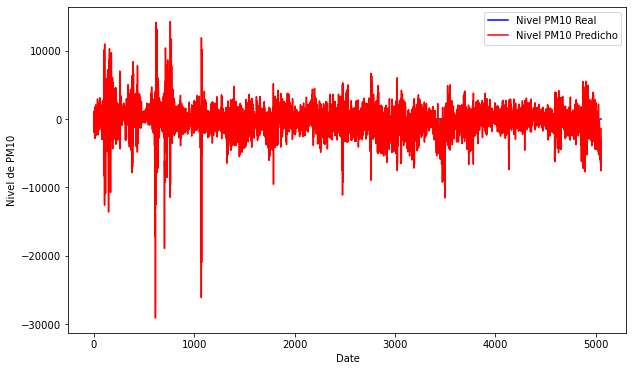

In [30]:
rmse_lr_5_pm10, mae_lr_5_pm10, preds_lr_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, LinearRegression())

Test Score Step 1
RMSE 3.01
MAE 1.95
Test Score Step 2
RMSE 25.69
MAE 17.02
Test Score Step 3
RMSE 183.74
MAE 121.97
Test Score Step 4
RMSE 1265.06
MAE 839.99
Test Score Step 5
RMSE 8644.30
MAE 5739.87
Test Score Step 6
RMSE 58982.86
MAE 39165.11
Test Score Step 7
RMSE 402350.60
MAE 267164.21
Test Score Step 8
RMSE 2744490.23
MAE 1822364.80
Test Score Step 9
RMSE 18720384.09
MAE 12430493.82
Test Score Step 10
RMSE 127693005.27
MAE 84789238.45


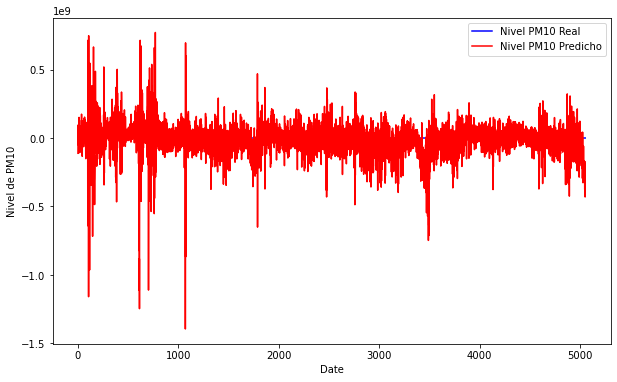

In [31]:
rmse_lr_10_pm10, mae_lr_10_pm10, preds_lr_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, LinearRegression())

Test Score Step 1
RMSE 3.26
MAE 2.05
Test Score Step 2
RMSE 28.25
MAE 18.18
Test Score Step 3
RMSE 201.84
MAE 130.13
Test Score Step 4
RMSE 1378.37
MAE 888.83
Test Score Step 5
RMSE 9319.06
MAE 6009.44
Test Score Step 6
RMSE 62868.21
MAE 40540.96
Test Score Step 7
RMSE 423924.27
MAE 273370.34
Test Score Step 8
RMSE 2858269.70
MAE 1843174.03
Test Score Step 9
RMSE 19271230.29
MAE 12427179.83
Test Score Step 10
RMSE 129931339.23
MAE 83787080.35
Test Score Step 11
RMSE 876028093.19
MAE 564912489.07
Test Score Step 12
RMSE 5906389473.92
MAE 3808774176.58
Test Score Step 13
RMSE 39822279387.12
MAE 25679659299.95
Test Score Step 14
RMSE 268491255493.62
MAE 173138355518.91
Test Score Step 15
RMSE 1810231741957.17
MAE 1167339868609.15


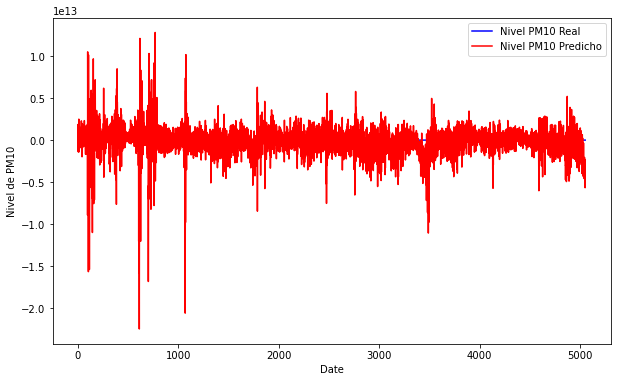

In [32]:
rmse_lr_15_pm10, mae_lr_15_pm10, preds_lr_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, LinearRegression())

## Random Forest

Test Score Step 1
RMSE 1.58
MAE 0.51
Test Score Step 2
RMSE 1.63
MAE 0.53
Test Score Step 3
RMSE 1.63
MAE 0.54
Test Score Step 4
RMSE 1.63
MAE 0.54
Test Score Step 5
RMSE 1.63
MAE 0.54


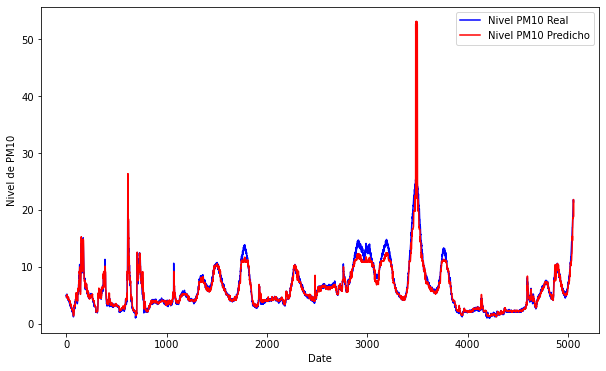

In [33]:
rmse_rf_5_pm10, mae_rf_5_pm10, preds_rf_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 0.76
MAE 0.45
Test Score Step 2
RMSE 0.80
MAE 0.47
Test Score Step 3
RMSE 0.80
MAE 0.48
Test Score Step 4
RMSE 0.81
MAE 0.48
Test Score Step 5
RMSE 0.81
MAE 0.48
Test Score Step 6
RMSE 0.81
MAE 0.48
Test Score Step 7
RMSE 0.81
MAE 0.48
Test Score Step 8
RMSE 0.81
MAE 0.49
Test Score Step 9
RMSE 0.81
MAE 0.48
Test Score Step 10
RMSE 0.81
MAE 0.48


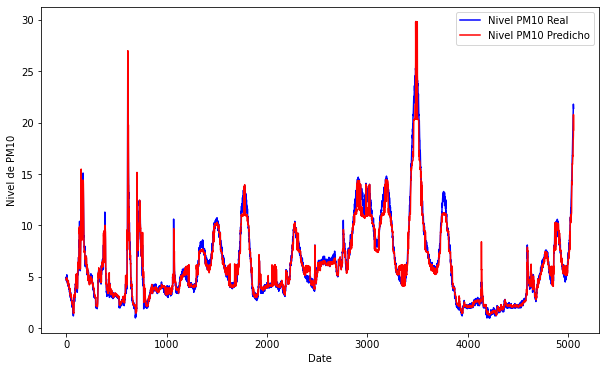

In [34]:
rmse_rf_10_pm10, mae_rf_10_pm10, preds_rf_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, RandomForestRegressor(random_state=seed_value))

Test Score Step 1
RMSE 0.85
MAE 0.51
Test Score Step 2
RMSE 0.90
MAE 0.54
Test Score Step 3
RMSE 0.91
MAE 0.55
Test Score Step 4
RMSE 0.92
MAE 0.55
Test Score Step 5
RMSE 0.92
MAE 0.55
Test Score Step 6
RMSE 0.92
MAE 0.55
Test Score Step 7
RMSE 0.92
MAE 0.56
Test Score Step 8
RMSE 0.91
MAE 0.55
Test Score Step 9
RMSE 0.91
MAE 0.55
Test Score Step 10
RMSE 0.91
MAE 0.55
Test Score Step 11
RMSE 0.91
MAE 0.55
Test Score Step 12
RMSE 0.91
MAE 0.55
Test Score Step 13
RMSE 0.90
MAE 0.55
Test Score Step 14
RMSE 0.90
MAE 0.55
Test Score Step 15
RMSE 0.90
MAE 0.55


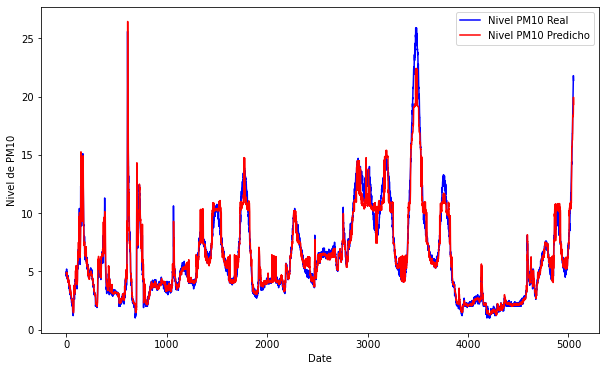

In [35]:
rmse_rf_15_pm10, mae_rf_15_pm10, preds_rf_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, RandomForestRegressor(random_state=seed_value))